In [39]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics.pairwise import rbf_kernel

In [40]:
# =============================================================================
# 0. Configuration: folders and image size
# =============================================================================
CLEAN_FOLDER = 'data\\anatomicalSegmentations'
DIST_FOLDER  = 'data\\anatomicalSegmentationsDistorted'
IMG_SIZE     = (64, 64)    # resize to 64×64

In [41]:
# =============================================================================
# 1. Load & preprocess images
# =============================================================================
def load_images_from_folder(folder, size=IMG_SIZE):
    """
    Loads all .png images from `folder`, resizes to `size`, returns array (N,H,W).
    """
    paths = sorted(glob(os.path.join(folder, '*.png')))
    imgs = []
    for p in paths:
        img = imread(p, as_gray=True)
        img = resize(img, size, anti_aliasing=True)
        imgs.append(img)
    return np.stack(imgs, axis=0)

In [42]:
clean_imgs = load_images_from_folder(CLEAN_FOLDER)   # (M,64,64)
dist_imgs  = load_images_from_folder(DIST_FOLDER)    # (K,64,64)
M, H, W    = clean_imgs.shape
K          = dist_imgs.shape[0]

# Vectorize to (N, 4096)
X_clean = clean_imgs.reshape(M, -1)
X_dist  = dist_imgs.reshape(K, -1)

In [43]:
# =============================================================================
# 2. Part 4(a): PCA on clean images
# =============================================================================
pca = PCA()
pca.fit(X_clean)

eigvals = pca.explained_variance_    # eigenvalues
pcs     = pca.components_            # principal components
mean_vec = pca.mean_                 # mean image vector

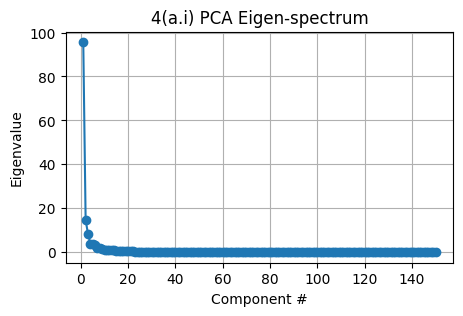

In [44]:
# 4(a.i) PCA eigen‑spectrum
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, len(eigvals)+1), eigvals, 'o-')
plt.title("4(a.i) PCA Eigen‑spectrum")
plt.xlabel("Component #")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

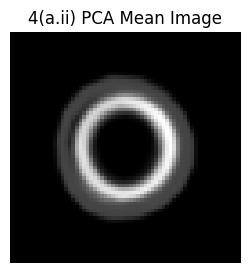

In [45]:
# 4(a.ii) PCA mean image
mean_img = mean_vec.reshape(H, W)
plt.figure(figsize=(3,3))
plt.imshow(mean_img, cmap='gray')
plt.title("4(a.ii) PCA Mean Image")
plt.axis('off')
plt.show()

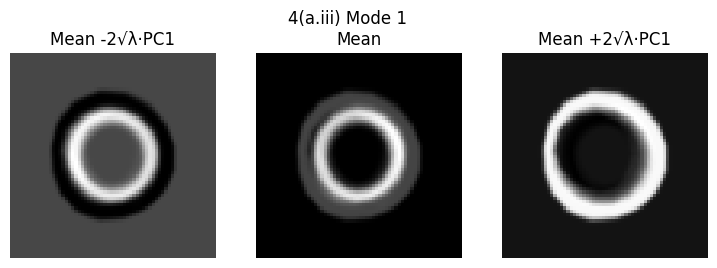

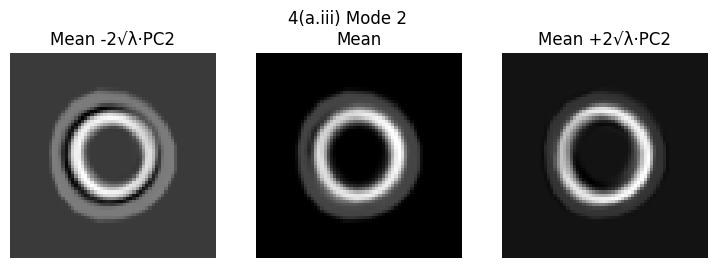

In [46]:
# 4(a.iii) First two modes ±2√λ
def plot_pca_mode(pc, eigval, idx):
    mode = pc.reshape(H, W)
    std = np.sqrt(eigval)
    fig, ax = plt.subplots(1,3, figsize=(9,3))
    ax[0].imshow(mean_img - 2*std*mode, cmap='gray'); ax[0].set_title(f"Mean -2√λ·PC{idx}")
    ax[1].imshow(mean_img, cmap='gray');              ax[1].set_title("Mean")
    ax[2].imshow(mean_img + 2*std*mode, cmap='gray'); ax[2].set_title(f"Mean +2√λ·PC{idx}")
    for a in ax: a.axis('off')
    plt.suptitle(f"4(a.iii) Mode {idx}")
    plt.show()

plot_pca_mode(pcs[0], eigvals[0], idx=1)
plot_pca_mode(pcs[1], eigvals[1], idx=2)

In [47]:
# =============================================================================
# 3. Part 4(b): Kernel PCA (RBF)
# =============================================================================
gamma = 1e-3
kpca = KernelPCA(kernel='rbf',
                 gamma=gamma,
                 fit_inverse_transform=True,
                 n_components=50)
kpca.fit(X_clean)

# 4(b.i) Compute and plot RKHS eigen‑spectrum manually
Kmat = rbf_kernel(X_clean, gamma=gamma)  # (M,M)
one_n = np.ones((M, M)) / M
Kc = Kmat - one_n @ Kmat - Kmat @ one_n + one_n @ Kmat @ one_n
eigvals_kpca, _ = np.linalg.eigh(Kc)
eigvals_kpca = np.sort(eigvals_kpca)[::-1]

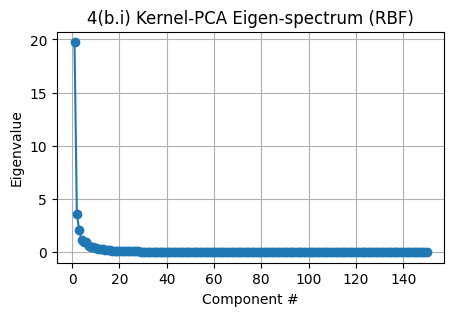

In [48]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, len(eigvals_kpca)+1), eigvals_kpca, 'o-')
plt.title("4(b.i) Kernel‑PCA Eigen‑spectrum (RBF)")
plt.xlabel("Component #")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

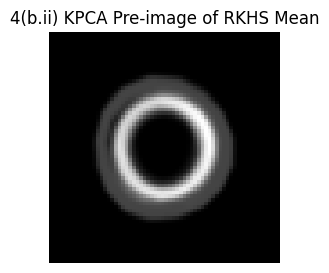

In [49]:
# 4(b.ii) Pre‑image of the RKHS mean
# The mean in feature space is the zero vector => reshape to (1, n_components)
zero_feat = np.zeros((1, kpca.n_components))
preimage = kpca.inverse_transform(zero_feat).reshape(H, W)

plt.figure(figsize=(3,3))
plt.imshow(preimage, cmap='gray')
plt.title("4(b.ii) KPCA Pre‑image of RKHS Mean")
plt.axis('off')
plt.show()

In [50]:
# =============================================================================
# 4. Part 4(c): Denoising distorted images
# =============================================================================
# (c.i) PCA reconstruction with first 3 PCs
pcs3 = pcs[:3]
recon_pca = []
for x in X_dist:
    coeffs = (x - mean_vec) @ pcs3.T
    x_rec  = mean_vec + coeffs @ pcs3
    recon_pca.append(x_rec.reshape(H, W))
recon_pca = np.stack(recon_pca, axis=0)

In [51]:
# (c.ii) KPCA reconstruction with first 3 kernel components
recon_kpca = []
for x in X_dist:
    z = kpca.transform(x.reshape(1,-1))[0]
    z3 = np.zeros_like(z)
    z3[:3] = z[:3]
    xk = kpca.inverse_transform(z3.reshape(1,-1)).reshape(H, W)
    recon_kpca.append(xk)
recon_kpca = np.stack(recon_kpca, axis=0)

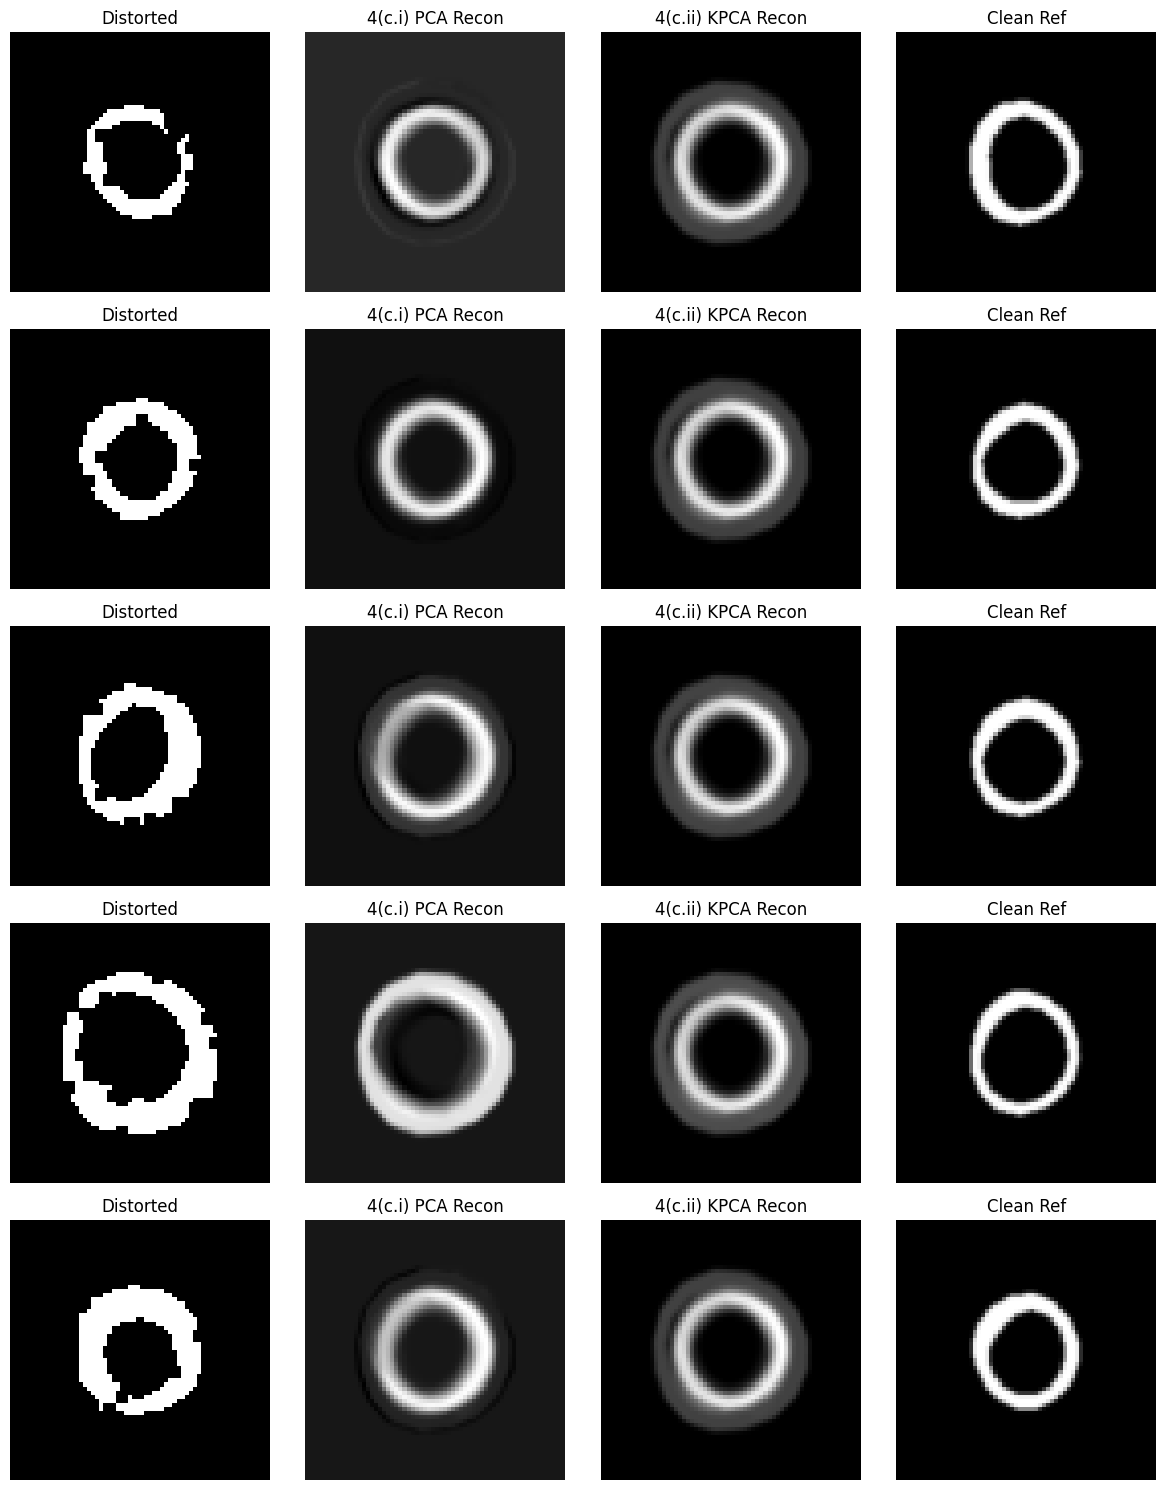

In [52]:
# Display comparisons
n_show = min(5, K)
fig, axs = plt.subplots(n_show, 4, figsize=(12, 3*n_show))
for i in range(n_show):
    axs[i,0].imshow(dist_imgs[i], cmap='gray'); axs[i,0].set_title("Distorted")
    axs[i,1].imshow(recon_pca[i], cmap='gray'); axs[i,1].set_title("4(c.i) PCA Recon")
    axs[i,2].imshow(recon_kpca[i], cmap='gray'); axs[i,2].set_title("4(c.ii) KPCA Recon")
    axs[i,3].imshow(clean_imgs[i], cmap='gray'); axs[i,3].set_title("Clean Ref")
    for j in range(4): axs[i,j].axis('off')
plt.tight_layout()
plt.show()